In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from signals import *
from frequencyestimator import *
import time
import copy

sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
sns.set_context("poster", font_scale = .45, rc={"grid.linewidth": 0.8})

<Figure size 640x480 with 0 Axes>

In [2]:
P0 = lambda n, theta: np.cos((2*n+1)*theta)**2
P1 = lambda n, theta: np.sin((2*n+1)*theta)**2

def estimate_signal(depths, n_samples, theta, eta=0.0):
        signals = np.zeros(len(depths), dtype = np.complex128)
        cos_signal = np.zeros(len(depths), dtype = np.complex128)
        for i,n in enumerate(depths):
            # Get the exact measuremnt probabilities
            p0 = P0(n, theta)
            p1 = P1(n, theta)

            p0x = P0x(n,theta)
            p1x = P1x(n,theta)

            # Get the "noisy" probabilities by sampling and adding a bias term that pushes towards 50/50 mixture
            eta_n = (1.0-eta)**(n+1) # The error at depth n increases as more queries are implemented
            p0_estimate = np.random.binomial(n_samples[i], eta_n*p0 + (1.0-eta_n)*0.5)/n_samples[i]
            p1_estimate = 1 - p0_estimate
            # p1_estimate = np.random.binomial(n_samples[i], eta_n*p1 + (1.0-eta_n)*0.5)/n_samples[i]
            p0x_estimate = np.random.binomial(n_samples[i], eta_n*p0x + (1.0-eta_n)*0.5)/n_samples[i]
            p1x_estimate = 1.0 - p0x_estimate
            
            # Estimate theta
            theta_estimated = np.arctan2(p0x_estimate - p1x_estimate, p0_estimate - p1_estimate)

            # estimate cos(2n+1)2theta
            # cos_signal[i] = p0_estimate - p1_estimate
            
            # Store this to determine angle at theta = 0 or pi/2
            if i==0:
                p0mp1 = p0_estimate - p1_estimate

            # Compute f(n) - Eq. 3
            fi_estimate = np.exp(1.0j*theta_estimated)
            # fi_estimate = 2*p0_estimate - 1 + 1.0j*np.sqrt(1-(2*p0_estimate - 1)**2)
            # fi_estimate = 2*p0_estimate - 1
            # fi_estimate = np.cos((2*n+1)*2*theta)
            # fi_estimate = np.exp(1.0j*(2*n+1)*2*theta)
            # fi_estimate = 2*p0 - 1 + np.random.normal(0.0, 1/n_samples[i])

            # signals[i] = np.real(fi_estimate)
            signals[i] = fi_estimate
         
        return signals    

## Test eigenvalues of R

In [3]:
a = 0.3
theta = np.arcsin(a)
w = 2*theta

q=4

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=10)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal) #don't know
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

random_signs = np.random.choice([-1, 1], size=len(signs))

print(signs)
#corrupt the signs
# signs[1:] = -1 * signs[1:]
# signs[1] = -1 * signs[1]
# signs[2] = -1 * signs[2]
print(random_signs)

csignal = cos_signal + 1.0j * random_signs * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)
theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)


fft1 = np.abs(np.fft.fft(R1/len(R1)))
fft2 = np.abs(np.fft.fft(R2/len(R2)))

print(f"max fourier coefficient: {(np.max(fft1), np.max(fft2))}")
print(f"l4 norm fourier coefficients: {(np.linalg.norm(fft1, 4), np.linalg.norm(fft2, 4))}")
# print(np.max(fft1), np.max(fft2))

# xaxis = [i*np.pi/(2*len(fft1)) for i in range(len(fft1))]
# plt.figure()
# plt.plot(xaxis, fft1)

# plt.figure()
# plt.plot(xaxis, fft2)
print(theta_est1, theta_est2)



depths:[  0   1   2   4   8  16  32  64 128]
[ 1.  1.  1. -1. -1.  1.  1.  1. -1.]
[-1 -1  1  1 -1  1  1 -1 -1]
max fourier coefficient: (0.3129892422502005, 0.9166791548999581)
l4 norm fourier coefficients: (0.4030051306587099, 0.9176572266363143)
1.3165112554777378 0.30437696852673346


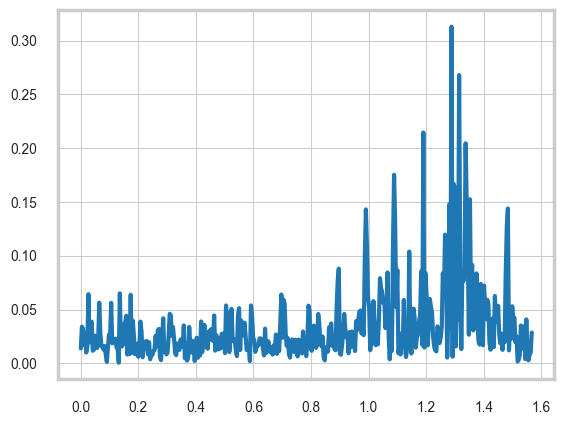

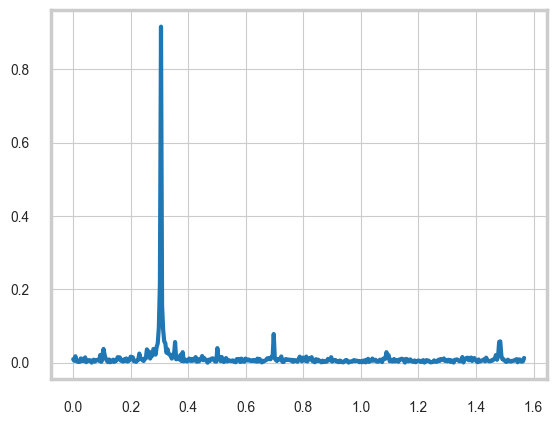

In [4]:
xaxis = [i*np.pi/(2*len(fft1)) for i in range(len(fft1))]
plt.figure()
plt.plot(xaxis, fft1)

plt.figure()
plt.plot(xaxis, fft2)

In [54]:
a = 0.3
theta = np.arcsin(a)
w = 2*theta

q=6

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=3)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal)
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

plusminus = [1, -1]

s = np.ones(len(signal))

for i in range(1, len(signal)):
    obj = np.zeros(2)
    ula = TwoqULASignal(M=narray[:i])
    # print(ula.depths)
    for j, sign in enumerate(plusminus):
        s[i] = sign
        csignal = cos_signal[:i+1] + 1.0j * s[:i+1] * abs_sin[:i+1]
        
        R = ula.get_cov_matrix_toeplitz(csignal)
        theta_est, _ = espirit.estimate_theta_toeplitz(R)

        # print(len(R))
        fft = np.abs(np.fft.fft(R)/len(R))
        # print(fft)
        # obj[j] = np.linalg.norm(fft, 4)
        # obj[j] = np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])
        obj[j] = np.abs(espirit.eigs[0])

        # obj[j] = np.max(fft)
    # print(R)
    signal2 = signal[:i+1]
    R_true = ula.get_cov_matrix_toeplitz(signal2)

    _, _ = espirit.estimate_theta_toeplitz(R_true)
    # print(f"true: {np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])}")
    print(f"true: {np.abs(espirit.eigs[0])}")

    fft_true = np.abs(np.fft.fft(R_true)/len(R_true))
    # print(fft)
    # print(np.linalg.norm(fft_true, 4))

    print(f"+1 -1: {obj}")
    idx = np.argmax(obj)
    s[i] = plusminus[idx]
        
# np.dot(signs, s)/len(s)

csignal = cos_signal + 1.0j * s * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)

theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)

print(signs, s)

theta_est1, theta_est2, theta

    

depths:[   0    1    2    4    8   16   32   64  128  256  512 1024 2048]
true: 1.1412540038565009
+1 -1: [0.94762028 0.13651602]
true: 2.9820614882031524
+1 -1: [2.99598325 2.98651056]
true: 8.961559052477298
+1 -1: [7.84824815 8.97032035]
true: 16.89332320715754
+1 -1: [14.63570529 16.94223618]
true: 48.2590854255355
+1 -1: [48.27537187 34.4784646 ]
true: 79.93093375660817
+1 -1: [80.13617811 57.14471031]
true: 222.05279708145278
+1 -1: [221.19058749 222.29587674]
true: 410.98816608370487
+1 -1: [405.49671712 412.21819006]
true: 1054.7724521299729
+1 -1: [ 606.93113197 1053.59280687]
true: 2054.611267529932
+1 -1: [2052.68139982 1780.01855374]
true: 4991.773928282597
+1 -1: [3469.2167287  5003.68744244]
true: 9862.657914634443
+1 -1: [9878.17135812 8391.00878524]
[ 1.  1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.] [ 1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.]


(0.304697062178194, 0.30469699690108726, 0.30469265401539747)

In [48]:
a = 0.4
theta = np.arcsin(a)
w = 2*theta

q=6

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=3)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal)
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

plusminus = [1, -1]

s = np.ones(len(signal))

for i in range(len(signal)//2):
    obj = {}
    ula = TwoqULASignal(M=narray[:2*i+1])
    # print(len(ula.depths), 2*i+2)
    # print(ula.depths)
    for j, sign1 in enumerate(plusminus):
        for k, sign2 in enumerate(plusminus):
            s[2*i] = sign1
            s[2*i+1] = sign2
            csignal = cos_signal[:2*i+2] + 1.0j * s[:2*i+2] * abs_sin[:2*i+2]
            # print(csignal)
            R = ula.get_cov_matrix_toeplitz(csignal)
            # print(R)
            theta_est, _ = espirit.estimate_theta_toeplitz(R)

            # print(len(R))
            # fft = np.abs(np.fft.fft(R)/len(R))
            # print(fft)
            # obj[j] = np.linalg.norm(fft, 4)
            # obj[j] = np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])
            obj[(sign1, sign2)] = np.abs(espirit.eigs[0])

        # obj[j] = np.max(fft)
    # print(R)
    signal2 = signal[:2*i+2]
    R_true = ula.get_cov_matrix_toeplitz(signal2)

    _, _ = espirit.estimate_theta_toeplitz(R_true)
    # print(f"true: {np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])}")
    print(f"true: {np.abs(espirit.eigs[0])}")

    # fft_true = np.abs(np.fft.fft(R_true)/len(R_true))
    # print(fft)
    # print(np.linalg.norm(fft_true, 4))

    print(f"+1 -1: {obj}")
    two_signs = max(obj, key=obj.get)
    s[2*i - 1] = two_signs[0]
    s[2*i] = two_signs[1]
        
# np.dot(signs, s)/len(s)

csignal = cos_signal + 1.0j * s * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)

theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)

print(signs, s)

theta_est1, theta_est2, theta


depths:[   0    1    2    4    8   16   32   64  128  256  512 1024 2048]
true: 1.0428375127979188
+1 -1: {(1, 1): 0.6796998390095353, (1, -1): 0.3693028273674158, (-1, 1): 0.19957713329341356, (-1, -1): 1.298434637137779}
true: 8.931067223993532
+1 -1: {(1, 1): 7.79364964212785, (1, -1): 8.931067223993535, (-1, 1): 8.013090237854804, (-1, -1): 6.16732857283123}
true: 48.22815601441064
+1 -1: {(1, 1): 24.904755033367287, (1, -1): 29.155185065491686, (-1, 1): 31.388595244506522, (-1, -1): 40.56140989089855}
true: 221.1553190784845
+1 -1: {(1, 1): 183.6010744393565, (1, -1): 147.2837199503581, (-1, 1): 182.62918612472262, (-1, -1): 142.2241209392057}
true: 1031.9701220819397
+1 -1: {(1, 1): 251.1004656610034, (1, -1): 333.6797788118925, (-1, 1): 270.2007919015349, (-1, -1): 349.7091186033821}
true: 4862.656814272104
+1 -1: {(1, 1): 985.7069236919756, (1, -1): 1269.907887818718, (-1, 1): 1348.5429448955858, (-1, -1): 1643.9862715188945}
[ 1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1.

(0.7606728916659735, 0.41147166539231633, 0.41151684606748806)

## Implement the above cell in a function

In [77]:
def estimate_amplitude(theta, narray, ula_signals, verbose=False):

    ula_signal = TwoqULASignal(M=narray, C=5)
    espirit = ESPIRIT()

    depths = ula_signal.depths
    n_samples = ula_signal.n_samples

    signal = estimate_signal(depths, n_samples, theta)
    cos_signal = np.real(signal)
    abs_sin = np.abs(np.imag(signal))

    plusminus = [1, -1]

    s = np.ones(len(signal))

    for i in range(1, len(signal)):
        obj = np.zeros(2)
        ula = ula_signals[i]
        for j, sign in enumerate(plusminus):
            s[i] = sign
            csignal = cos_signal[:i+1] + 1.0j * s[:i+1] * abs_sin[:i+1]
            
            R = ula.get_cov_matrix_toeplitz(csignal)
            _, _ = espirit.estimate_theta_toeplitz(R)
            obj[j] = np.abs(espirit.eigs[0])
        # signal2 = signal[:i+1]
        # R_true = ula.get_cov_matrix_toeplitz(signal2)

        # _, _ = espirit.estimate_theta_toeplitz(R_true)
        # # print(f"true: {np.abs(espirit.eigs[0])/np.abs(espirit.eigs[1])}")
        # print(f"true: {np.abs(espirit.eigs[0])}")

        # fft_true = np.abs(np.fft.fft(R_true)/len(R_true))
        # # print(fft)
        # # print(np.linalg.norm(fft_true, 4))
        if verbose:
            print(f"+1 -1: {obj}")
        idx = np.argmax(obj)
        s[i] = plusminus[idx]
            
    # np.dot(signs, s)/len(s)

    csignal = cos_signal + 1.0j * s * abs_sin

    R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
    # R2 = ula_signal.get_cov_matrix_toeplitz(signal)

    theta_est1, _ = espirit.estimate_theta_toeplitz(R1)

    # theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)

    return theta_est1

In [96]:
a = 0.8
theta = np.arcsin(a)
w = 2*theta

q=6

narray = [2]*(2*q)
ula_signal = TwoqULASignal(M=narray, C=5)
depths = ula_signal.depths

ula_signals = [ula_signal]
for i in range(1, len(depths)):
    ula = TwoqULASignal(M=narray[:i])
    ula_signals.append(ula)

num_mc=10
thetas = np.zeros(num_mc)
errors = np.zeros(num_mc)
for i in range(num_mc):
    theta_est = estimate_amplitude(theta, narray, ula_signals)
    error = np.abs(np.sin(theta)-np.sin(theta_est)) 
    thetas[i] = theta_est            
    errors[i] = error

print(f'Ave theta estimated: {np.mean(thetas)}')
print(f'a = {np.sin(theta)}; a_est = {np.sin(np.mean(thetas))}')
print(f'99% percentile: {np.percentile(errors, 99):e}')
print(f'95% percentile: {np.percentile(errors, 95):e}')
print(f'68% percentile: {np.percentile(errors, 68):e}')
print()

Ave theta estimated: 1.1482032945860898
a = 0.8; a_est = 0.9120285357896261
99% percentile: 1.911411e-01
95% percentile: 1.557620e-01
68% percentile: 1.016955e-01



In [97]:
thetas,theta

(array([1.12367274, 1.12359962, 1.1236619 , 1.12366713, 1.12369236,
        1.12371006, 1.12359049, 1.56547372, 1.12357776, 0.92738715]),
 0.9272952180016123)

In [91]:
np.sin(np.pi/4)

0.7071067811865475

## Brute force try all signs

In [6]:
a = 0.3
theta = np.arcsin(a)
w = 2*theta

q=4

narray = [2]*(2*q)

ula_signal = TwoqULASignal(M=narray, C=5)
espirit = ESPIRIT()

depths = ula_signal.depths
n_samples = ula_signal.n_samples
# n_samples = [100 for _ in depths]
print(f'depths:{depths}')

signal = estimate_signal(depths, n_samples, theta)
cos_signal = np.real(signal)
sin_signal = np.imag(signal)
abs_sin = np.abs(sin_signal)

signs = np.sign(sin_signal) #these are the correct signs

import itertools

def generate_sign_combinations(n):
    signs = [-1, 1]
    combinations = [np.array(combo) for combo in itertools.product(signs, repeat=n)]
    return combinations

# Example usage:
n = len(signal)

combinations = generate_sign_combinations(n)
obj = np.zeros(len(combinations))

for i, combo in enumerate(combinations):
    s = combo
    csignal = cos_signal + 1.0j * s * abs_sin
    R = ula.get_cov_matrix_toeplitz(csignal)
    # print(len(R))
    fft = np.abs(np.fft.fft(R)/len(R))
    # print(fft)
    norm = np.linalg.norm(fft, 4)
    obj[j] = norm
    print(norm)
    # obj[j] = np.max(fft)
        
# np.dot(signs, s)/len(s)
idx = np.argmax(obj)
s = combinations[idx]

csignal = cos_signal + 1.0j * s * abs_sin

R1 = ula_signal.get_cov_matrix_toeplitz(csignal)
R2 = ula_signal.get_cov_matrix_toeplitz(signal)

theta_est1, eigs1 = espirit.estimate_theta_toeplitz(R1)

theta_est2, eigs2 = espirit.estimate_theta_toeplitz(R2)

print(signs, s)

theta_est1, theta_est2, theta

    

depths:[  0   1   2   4   8  16  32  64 128]
nan
0.0
0.0
0.0
0.0
0.0
0.12068062199407506
0.1252767008851752
0.11917345302969895
0.12118750798879446
0.12261857320073623
nan
0.0
nan
0.0
0.0
0.0
0.0
0.12259415792360327
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.12061027681666485
0.12135298604615558
0.11756497107379389
0.11766168193284371
0.0
0.115275180471296
0.12011294011122656
0.11539850932748001
0.11819681334036553
0.12509063308481688
0.1264825215485083
0.11797058215747284
0.12176680133330675
0.12304192286043003
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.11644970513466045
0.1179445211265014
0.11608936473844104
nan
nan
nan
nan
nan
nan
nan
nan
0.0
0.0
0.0
0.0
0.0
0.0
0.11735650351165143
0.12393512524727568
0.12019886285454626
0.12390608560096374
0.1204092441562583
0.1275940354101096
0.12818329117785385
0.12797182804767665
0.12334718493309134
0.11901311239042546
0.11777364517857601
0.1191702829791717
0.1211778472779982
0.0
0.0
0.1184865707413049
0.1177060

(1.1655432455543402, 0.30385476501593134, 0.30469265401539747)

In [7]:
obj[idx]

0.0

# Signal estimates on linear array

Use fft to find the angles when sampling the cosine on a linear array (so depths 0,1,2,3,4.., 1000 for example).
Theoretically this should give the correct peaks.
Also use ESPIRIT to find the peaks.

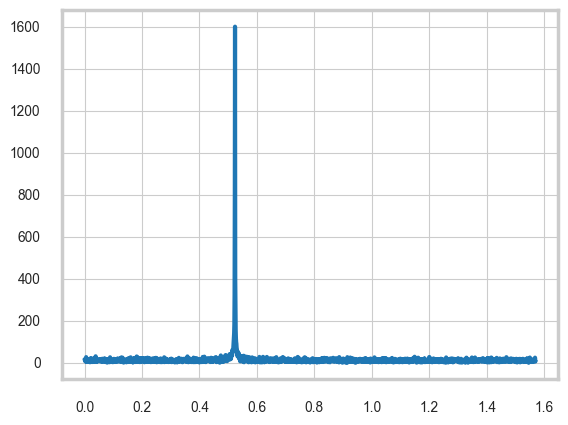

In [8]:
# Set the actual amplitude
theta = np.pi/6

theta1 = np.pi/5
theta2 = -theta1

depths = [i for i in range(2000)]
n_samples = [10 for d in depths]

R = estimate_signal(depths, n_samples, theta)

# R = [0.5*np.exp(1j*theta1*(2*d+1)) + 0.5*np.exp(1j*theta2*(2*d+1)) for d in depths]

fft = np.abs(np.fft.fft(R))

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

In [9]:
# amax = np.argmax(fft[:len(fft)//2])
amax = np.argmax(fft)
print(f'theta: {theta}')
print('peaks:', np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)))

theta: 0.5235987755982988
peaks: 1.0469357518087987 0.523860574986098


In [10]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/4}')
print(f'theta_est: {theta_est}')
print(f'theta: {theta}')
np.sum(np.abs(angle))/8

angles: [-0.12425222+0.21567508j -0.0195024 +0.10343269j]
theta_est: 0.5233657982698127
theta: 0.5235987755982988


0.17708077594057944

$(c_1 + x_1 i s_1, c_2 + x_2 i s_2, c_4 + x_4 i s_4)$

$(c_1 + x_1 i s_1)\cdot (c_2 + x_2 i s_2)$

## Get the real signal values on virtual locations 
One can do this using Chebyshev polynomials with the recurrence $\cos(nx) = 2\cos(x)\cos((n-1)x) - \cos((n-2)x)$

[0.31622777+0.9486833j]
0.30155270333819445


/Users/farrokhlabib/Documents/github/csAE/.venv/lib/python3.10/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: overflow encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


(1.5707963267948966, 0.0, 0.6283185307179586)

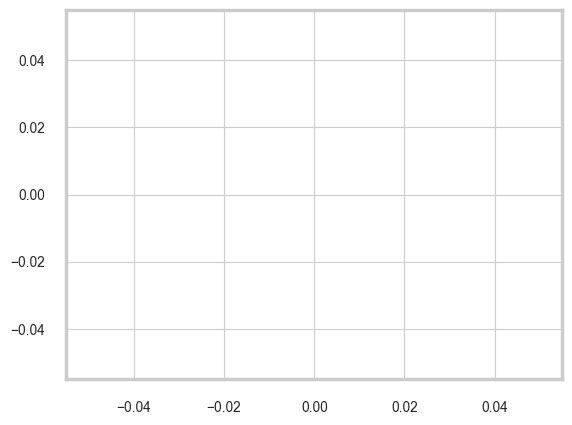

In [11]:
from scipy.special import chebyt, chebyu

def get_cheb_vals(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
        R[n] = chebyt(2*n+1)(np.cos(w))
    return R

def get_cosine_values(n_max, w):
    R = np.zeros(n_max)
    for n in range(n_max):
         R[n] = np.cos((2*n+1)*w)
    return R

# For reproducibility
# np.random.seed(8)

theta = np.pi/5
w = 2*theta

# depths = [0] + [2**i for i in range(6)]
depths = [0]
# n_samples = [(d_max - d)//2 + 1 for d in depths]
n_samples = [400 for _ in depths]

R = estimate_signal(depths, n_samples, theta)
print(R)
S = np.cos(w) + np.random.normal(0.0,1/100)
print(S)
vR = [chebyt(2*n+1)(R[0]) for n in range(500)]
R = vR
# R = get_cheb_vals(d_max, w)
# R = get_cosine_values(d_max, w)

fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[1:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)), np.pi*(amax)/(2*len(fft)), theta

In [12]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle/2}')
print(f'theta_est: {2*theta_est}')
print(f'w: {w}')
np.sum(np.abs(angle))/4

LinAlgError: SVD did not converge

This seems to work: Sample at depth 0 to get an approximation of $T_1(\cos(\omega)) = \cos(\omega)$ and use Chebyshev polynomials to get $T_{2n+1}(\cos(\omega)) = \cos((2n+1)\omega)$ and use ESPRIT or FFT.

Unfortunately, the scaling in this case is no better than classical since $|T_n(\cos(\omega)) - T_n(x)|< n\epsilon$ if $x = \cos(\omega)+\epsilon$ ($x$ being a noisy version of $\cos(\omega)$).

In [ ]:
[2**k + 1 for k in range(1,9)]

[3, 5, 9, 17, 33, 65, 129, 257]

depths:[0, 1, 2, 4, 8, 16, 32]
idx_vals:[1, 3, 5, 9, 17, 33, 65]
{1: 0.30901699437494745, 3: -0.8090169943749475, 5: 1.0, 9: 0.309016994374947, 17: -0.8090169943749469, 33: -0.8090169943749483, 65: 1.0}
64


(0.9326603190344698, 0.6381360077604268, 0.6283185307179586)

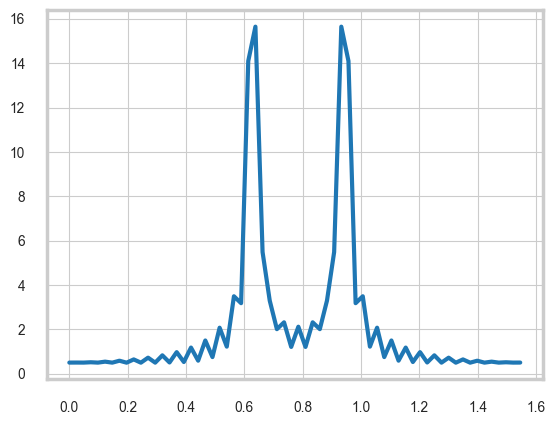

In [ ]:
theta = np.pi/5# np.arccos(a)
w = 2*theta

q=6

depths = [0] + [2**i for i in range(q)]
n_samples = [100 for _ in depths]
print(f'depths:{depths}')

idx = [0]*

S = estimate_signal(depths, n_samples, theta)



fft = np.abs(np.fft.fft(R))

amax = np.argmax(fft[:len(fft)//2])

xaxis = [i*np.pi/(2*len(fft)) for i in range(len(fft))]

plt.plot(xaxis, fft)

np.pi*(len(fft)-amax)/(2*len(fft)) , np.pi*(amax)/(2*len(fft)), theta

In [ ]:
R = R[:len(R)//2]
len(R)

256

In [ ]:
espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(R)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')
np.sum(np.abs(angle))/4

angles: [ 2.41720381 -2.41720381]
w: 2.0943951023931953
theta_est: 0.9664953736318308
theta:1.0471975511965976


1.2086019063261315

In [ ]:
theta = np.pi/5
w = 2*theta
depths = [d for d in range(4000)]
n_samples = [10 for d in depths]
complex_signal = estimate_signal(depths=depths, n_samples=n_samples, theta=theta)

espirit = ESPIRIT()

theta_est, angle = espirit.estimate_theta_toeplitz(complex_signal)
print(f'angles: {angle}')
print(f'w: {w}')
print(f'theta_est: {theta_est}')
print(f'theta:{theta}')

angles: [-2.51423504 -2.51474992]
w: 1.2566370614359172
theta_est: 0.6285587590036431
theta:0.6283185307179586


We need to solve the sign ambiguity at each depth. Consider the following approach.

Suppose we know $\cos(\omega)$, this implies $\sin(\omega) = \pm \sqrt{1-\cos^2(\omega)}$.

Choose a sign, say $+$. Then we form the exponential $e^{i\omega} = \cos(\omega) + i\sin(\omega)$.

Next we obtain $\cos(3\omega)$ as well and also choose $+$ for the sign, so we have $e^{i3\omega} = \cos(3\omega) + i\sin(3\omega)$.

Then, knowing $\cos(5\omega)$ determines if the chosen signs are consistent.

In [ ]:
w = np.random.random()*np.pi
w

1.2734564911263488

In [ ]:
std = 1/10**4

cos1 = np.cos(w) + np.random.normal(0.0, std)
sin1 = np.sqrt(1-cos1**2)

cos3 = np.cos(3*w) + np.random.normal(0.0, std)
sin3 = np.sqrt(1-cos3**2)

cos5 = np.cos(5*w) + np.random.normal(0.0, std)
sin5 = np.sqrt(1-cos5**2)

print(np.isclose(cos5, np.real((cos1+1.0j*sin1)**2*(cos3-1.0j*sin3)), rtol=0.01))

cos9 = np.cos(9*w) + np.random.normal(0.0, std)

print(np.isclose(cos9, np.real((cos1+1.0j*sin1) * (cos3-1.0j*sin3) * (cos5+1.0j*sin5)), rtol=0.01))

True
True


In [ ]:
q = 3

s = [1] + [2**k+1 for k in range(1, q+1)]
s

[1, 3, 5, 9]

In [ ]:
s[-1] - 2*s[0], s[-2] - s[0] + s[-3]# - s[0] + s[-4] - s[0] + s[-5]# - s[0]# + s[-6] - s[0] + s[-7] - s[0] + s[-8] - s[0] + s[-9]

(3, 3)

In [ ]:
def sign_ambiguity(signal):
    # returns a list of signs at each depth
    signs = [1] #we can choose the first sign freely
    rtol = 0.01
    sines = np.sqrt(1 - signal**2)
    csignal = [signal[0] + signs[0]*1.0j*sines[0]] #first complex signal

    for i in range(1, len(signal) - 1):
        for sign in [-1, 1]:
            cs = signal[i] + sign*1.0j*sines[i]
            cs = cs * csignal[0]**2
            for j in range(i):
                cs = cs*csignal[j]*np.conj(csignal[0])

            if np.isclose(signal[i+1], np.real(cs), rtol=rtol):
                signs.append(sign)
                csignal.append(signal[i] + sign*1.0j*sines[i])
                break

    return signs, csignal

In [ ]:
signal = np.array([np.cos(i*w)+np.random.normal(0.0, std) for i in s])
signal

array([ 0.29296457, -0.77816886,  0.99651255,  0.44893816])

In [ ]:
sign_ambiguity(signal=signal)

([1, -1, 1],
 [(0.29296456924427944+0.9561232980988977j),
  (-0.778168857053688-0.6280551169378026j),
  (0.9965125488285425+0.08344303462387884j)])